# 20.8 Challenge

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Dealing-with-missing-values" data-toc-modified-id="Dealing-with-missing-values-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Dealing with missing values</a></span><ul class="toc-item"><li><span><a href="#Updating-missing-values-using-the-world-bank-API" data-toc-modified-id="Updating-missing-values-using-the-world-bank-API-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Updating missing values using the world bank API</a></span></li><li><span><a href="#Interpolating-and-dropping-remaining-missing-values" data-toc-modified-id="Interpolating-and-dropping-remaining-missing-values-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Interpolating and dropping remaining missing values</a></span></li></ul></li><li><span><a href="#Dealing-with-outliers" data-toc-modified-id="Dealing-with-outliers-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Dealing with outliers</a></span><ul class="toc-item"><li><span><a href="#Using-Tukey's-method-to-visualise-outliers-for-each-country" data-toc-modified-id="Using-Tukey's-method-to-visualise-outliers-for-each-country-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Using Tukey's method to visualise outliers for each country</a></span></li><li><span><a href="#Winsorizing-outliers" data-toc-modified-id="Winsorizing-outliers-0.2.2"><span class="toc-item-num">0.2.2&nbsp;&nbsp;</span>Winsorizing outliers</a></span></li></ul></li><li><span><a href="#Converting-numeric-columns-to-float-and-'Status'-to-dummy" data-toc-modified-id="Converting-numeric-columns-to-float-and-'Status'-to-dummy-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Converting numeric columns to float and 'Status' to dummy</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Exploration</a></span></li></ul></div>

In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who/home) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

`postgres_user = 'dsbc_student'
postgres_pw = '7\*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'`

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

## Data cleaning

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

data = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

In [4]:
data.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [5]:
data.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [6]:
data.describe()

Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2928.000000      2928.000000    2938.000000   
mean   2007.518720         69.224932       164.796448      30.303948   
std       4.613841          9.523867       124.292079     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.100000        74.000000       0.000000   
50%    2008.000000         72.100000       144.000000       3.000000   
75%    2012.000000         75.700000       228.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000     1.000000       0.000000   
25%       0.877500                4.685343    77.000000       0.000000   
50%       3.755000               64.912906    92.000000      17.000000   
75%       7.702500              441.534144    97.000000     360.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

              BMI   under-five deaths         Polio  Total expenditure  \
count  2904.000000         2938.000000  2919.000000         2712.00000   
mean     38.321247           42.035739    82.550188            5.93819   
std      20.044034          160.445548    23.428046            2.49832   
min       1.000000            0.000000     3.000000            0.37000   
25%      19.300000            0.000000    78.000000            4.26000   
50%      43.500000            4.000000    93.000000            5.75500   
75%      56.200000           28.000000    97.000000            7.49250   
max      87.300000         2500.000000    99.000000           17.60000   

       Diphtheria      HIV/AIDS            GDP    Population  \
count  2919.000000  2938.000000    2490.000000  2.286000e+03   
mean     82.324084     1.742103    7483.158469  1.275338e+07   
std      23.716912     5.077785   14270.169342  6.101210e+07   
min       2.000000     0.100000       1.681350  3.400000e+01   
25%      78.000000     0.100000     463.935626  1.957932e+05   
50%      93.000000     0.100000    1766.947595  1.386542e+06   
75%      97.000000     0.800000    5910.806335  7.420359e+06   
max      99.000000    50.600000  119172.741800  1.293859e+09   

        thinness  1-19 years   thinness 5-9 years  \
count            2904.000000          2904.000000   
mean                4.839704             4.870317   
std                 4.420195             4.508882   
min                 0.100000             0.100000   
25%                 1.600000             1.500000   
50%                 3.300000             3.300000   
75%                 7.200000             7.200000   
max                27.700000            28.600000   

       Income composition of resources    Schooling  
count                      2771.000000  2775.000000  
mean                          0.627551    11.992793  
std                           0.210904     3.358920  
min                           0.000000     0.000000  
25%                           0.493000    10.100000  
50%                           0.677000    12.300000  
75%                           0.779000    14.300000  
max                           0.948000    20.700000

In [7]:
len(data['Country'].unique())

193

### Dealing with missing values

In [8]:
data2 = data.copy()
print(id(data), id(data2))

112065893776 112100046160


In [9]:
data2 = data2.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
data2.columns = data2.columns.str.strip()

In [10]:
data.isna().sum()/data.isna().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.066031
percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
 BMI                               0.011572
under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
 HIV/AIDS                          0.000000
GDP                                0.152485
Population                         0.221920
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

Some variables contain missing values, so we start by interpolating the data for a given country.

In [11]:
for country in data2['Country'].unique():
    data2.loc[data2['Country'] == country] = data2.loc[data2['Country'] == country].interpolate()
    
data.isna().sum()/data.isna().count() - data2.isna().sum()/data2.isna().count()

 BMI                                    NaN
 HIV/AIDS                               NaN
 thinness  1-19 years                   NaN
 thinness 5-9 years                     NaN
Adult Mortality                    0.000000
Alcohol                            0.000681
BMI                                     NaN
Country                            0.000000
Diphtheria                              NaN
Diphtheria                              NaN
GDP                                0.008850
HIV/AIDS                                NaN
Hepatitis B                        0.139210
Income composition of resources    0.000000
Life expectancy                         NaN
Life expectancy                         NaN
Measles                                 NaN
Measles                                 NaN
Polio                              0.006467
Population                         0.000000
Schooling                          0.000000
Status                             0.000000
Total expenditure               

There still remain some missing values, so we dive deeper into the types of missing values.

In [12]:
data2.shape

(2938, 22)

In [13]:
data2.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            192
percentage expenditure               0
Hepatitis B                        144
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                                0
Total expenditure                  210
Diphtheria                           0
HIV/AIDS                             0
GDP                                422
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

#### Updating missing values using the world bank API

Since GDP and Population are fairly common stats, we will try use a public world-bank to fill in some of the values. First, we must get the country codes (the format used by the worldbank), and merge these values with the overall data.

In [178]:
import world_bank_data as wb

country_codes = wb.get_countries()[['iso2Code', 'name', 'region']]
country_codes.rename(columns = {'name':'Country'}, inplace = True)
country_codes.head()

iso2Code      Country                      region
id                                                   
ABW       AW        Aruba  Latin America & Caribbean 
AFG       AF  Afghanistan                  South Asia
AFR       A9       Africa                  Aggregates
AGO       AO       Angola         Sub-Saharan Africa 
ALB       AL      Albania       Europe & Central Asia

In [66]:
data3 = data2.merge(country_codes, on='Country', how = 'left')
data3['Country'].loc[data3['iso2Code'].isna()].value_counts()[:15]

Republic of Korea                            16
Swaziland                                    16
Egypt                                        16
Kyrgyzstan                                   16
Saint Vincent and the Grenadines             16
Republic of Moldova                          16
The former Yugoslav republic of Macedonia    16
Gambia                                       16
Congo                                        16
Saint Lucia                                  16
Democratic People's Republic of Korea        16
Bahamas                                      16
Slovakia                                     16
Democratic Republic of the Congo             16
United States of America                     16
Name: Country, dtype: int64

We notice that some of the countries have not automatically merged on the isoCode.

In [67]:
manual_codes = {
    'Republic of Korea': "KR",
    'Egypt': "EG",
    'Kyrgyzstan': "KG",
    'Saint Vincent and the Grenadines': "VC",
    'Republic of Moldova': "MD",
    'The former Yugoslav republic of Macedonia': "MK",
    'Gambia': "GM",
    'Congo': "CG",
    'Saint Lucia': "LC",
    "Democratic People's Republic of Korea": "KP",
    'Bahamas': "BS",
    'Slovakia': "SK",
    "Democratic Republic of the Congo": "CD",
    "United States of America": "US",
    "Lao People's Democratic Republic": "LA",
    "Iran (Islamic Republic of)": "IR",
    "Côte d'Ivoire": "CI",
    "Czechia": "CZ",
    "United Republic of Tanzania": "TZ",
    "Venezuela (Bolivarian Republic of)": "VE",
    'Yemen': "YE",
    'Micronesia (Federated States of)': "FM",
    'Bolivia (Plurinational State of)': "BO",
    'Viet Nam': "VN",
    'United Kingdom of Great Britain and Northern Ireland': "GB",
    'Saint Kitts and Nevis': "KN"
}

for country in manual_codes:
    data3['iso2Code'].loc[data3['Country'] == country] = manual_codes[country]
    
data3['Country'].loc[data3['iso2Code'].isna()].value_counts()[:15]

Swaziland       16
Cook Islands     1
Niue             1
Name: Country, dtype: int64

We first get the list of countries with missing GDP and population values, with the respective year.

In [92]:
missingvals = data3.loc[(data3['Population'].isna()) | (data3['GDP'].isna())]
missingvals = missingvals[['Country', 'Year', 'GDP', 'Population', 'iso2Code']]
len(missingvals)

661

In [181]:
missingvals.loc[missingvals]

Lao People's Democratic Republic                        16
Bahrain                                                 16
Yemen                                                   16
Libya                                                   16
Viet Nam                                                16
Micronesia (Federated States of)                        16
Congo                                                   16
Venezuela (Bolivarian Republic of)                      16
Czechia                                                 16
Côte d'Ivoire                                           16
United States of America                                16
Egypt                                                   16
Somalia                                                 16
Slovakia                                                16
Republic of Korea                                       16
Saint Lucia                                             16
Gambia                                                  

And lastly, we complete the missing data for each given country, year, and variable.

In [113]:
import math

counter = 0

for index, code in enumerate(missingvals['iso2Code'].unique()):
    years_updated = set()
    
    for year in missingvals['Year'].loc[missingvals['iso2Code'] == code].unique():
  
        country = missingvals['Country'].loc[(missingvals['iso2Code'] == code) & (missingvals['Year'] == year)].values[0]
        current_gdp = missingvals['GDP'].loc[(missingvals['iso2Code'] == code) & (missingvals['Year'] == year)].values[0]
        current_pop = missingvals['Population'].loc[(missingvals['iso2Code'] == code) & (missingvals['Year'] == year)].values[0]
        
        
        try:
            new_pop = wb.get_series('SP.POP.TOTL', date = year, country = code).values[0] 
            new_gdp = wb.get_series('GDP (current $)	', date = year, country = code).values[0]
        except:
            pass
            
                
        data3['GDP'].loc[(data3['iso2Code'] == code) & (data3['Year'] == year)] = new_gdp
        data3['Population'].loc[(data3['iso2Code'] == code) & (data3['Year'] == year)] = new_pop
        
    print('GDP and Population for {} ({}) updated.'.format(country, code))

GDP and Population for Côte d'Ivoire (CI) updated.
GDP and Population for Antigua and Barbuda (AG) updated.
GDP and Population for Bahamas (BS) updated.
GDP and Population for Bahrain (BH) updated.
GDP and Population for Barbados (BB) updated.
GDP and Population for Bolivia (Plurinational State of) (BO) updated.
GDP and Population for Brunei Darussalam (BN) updated.
GDP and Population for Congo (CG) updated.
GDP and Population for Congo (nan) updated.
GDP and Population for Cuba (CU) updated.
GDP and Population for Czechia (CZ) updated.
GDP and Population for Democratic People's Republic of Korea (KP) updated.
GDP and Population for Democratic Republic of the Congo (CD) updated.
GDP and Population for Dominica (DM) updated.
GDP and Population for Egypt (EG) updated.
GDP and Population for Slovakia (SK) updated.
GDP and Population for Eritrea (ER) updated.
GDP and Population for Gambia (GM) updated.
GDP and Population for Grenada (GD) updated.
GDP and Population for Iran (Islamic Republ

And lastly, we need to update the larger data file with these new values.

In [114]:
data4 = data3.merge(missingvals, on=['Country', 'Year', 'iso2Code'], suffixes=('_old', '_new'), how = 'outer')
data4['Population_new'].fillna(data4['Population_old'], inplace = True)
data4['GDP_new'].fillna(data4['GDP_old'], inplace = True)
data4.drop(columns = ['Population_old', 'GDP_old'], inplace = True)

data4.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            192
percentage expenditure               0
Hepatitis B                        144
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                                0
Total expenditure                  210
Diphtheria                           0
HIV/AIDS                             0
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
iso2Code                            18
region                             419
GDP_new                              2
Population_new                       6
dtype: int64

#### Interpolating and dropping remaining missing values

We notice that there are still quite a few missing variables. To best determine the course of action, we create a heatmap to see which variables currently have the highest correlation with Life Expectancy.

(20.0, 0.0)

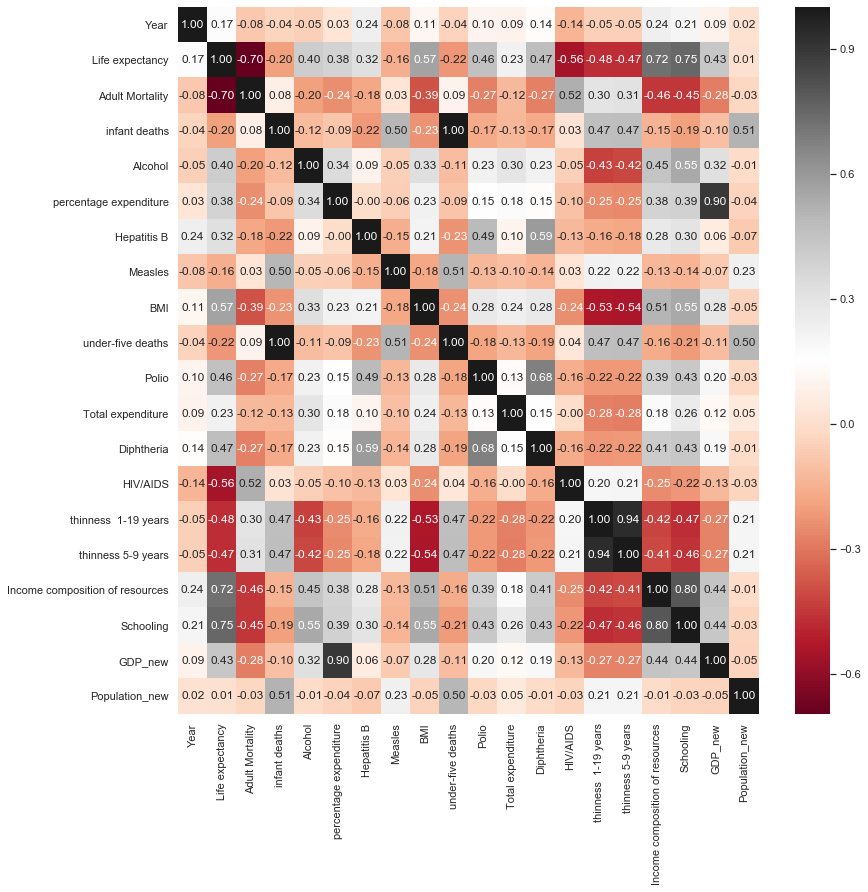

In [115]:
corr = data4.corr()

plt.figure(figsize=(13, 13))
ax = sns.heatmap(corr, annot=True, fmt = '.2f', cmap='RdGy')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From this heat map, we see that `Adult mortality`, `BMI`, `HIV/AIDS`, `Income composition of resources` and `Schooling` have some of the highest absolute values for correlation, and none of them seem to be missing in a very high proportion, so we can just interpolate the missing values and carry on.

In [180]:
len(data4)

2938

In [116]:
data4.isna().sum()/data4.isna().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.065351
percentage expenditure             0.000000
Hepatitis B                        0.049013
Measles                            0.000000
BMI                                0.011572
under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  0.071477
Diphtheria                         0.000000
HIV/AIDS                           0.000000
thinness  1-19 years               0.011572
thinness 5-9 years                 0.011572
Income composition of resources    0.056841
Schooling                          0.055480
iso2Code                           0.006127
region                             0.142614
GDP_new                         

In [138]:
numeric_cols = ['Adult Mortality',
               'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
               'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
               'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years', 'thinness 5-9 years',
               'Income composition of resources', 'Schooling',
               'GDP_new', 'Population_new']

In [118]:
for country in data4['Country'].unique():
    for col in numeric_cols:
        data4[col].loc[data4['Country'] == country] = data4[col].loc[data4['Country']
                                                                     == country].interpolate(kind='time')

In [119]:
data4.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            192
percentage expenditure               0
Hepatitis B                        144
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                                0
Total expenditure                  210
Diphtheria                           0
HIV/AIDS                             0
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
iso2Code                            18
region                             419
GDP_new                              2
Population_new                       6
dtype: int64

...and we drop the remaining null values.

In [120]:
data_temp = data4.copy()

In [124]:
#data4.dropna(inplace = True)
data4 = data_temp.copy()

### Dealing with outliers

#### Using Tukey's method to visualise outliers for each country

In [125]:
def tukeys_visualizers(dataframe, list_of_cols, only_outliers = False):
    
    return_test = False
    
    cols_with_outliers = []
    
    for col in list_of_cols:
        #print("Calculating outliers for:", col)
        q75, q25 = np.percentile(dataframe[col], [75, 25])
        iqr = q75 - q25

        outliers = []
        thresholds = []

        for threshold in np.arange(1, 15, 0.5):
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)

            outlier_count = len((np.where((dataframe[col] > max_val) | (dataframe[col] < min_val))[0]))

            outliers.append(outlier_count)
            thresholds.append(threshold)

        visuals = pd.Series(outliers, thresholds)
        
        if visuals[3.0] > 0:
            visuals.plot(label = col)
            
            cols_with_outliers.append(col)
            
            return_test = True
    
            plt.legend()
            plt.xlabel('IQR Threshold')
            plt.ylabel('Number of outliers')
            plt.xticks(ticks = range(1, 15))
                      
    if only_outliers:
        return (return_test, cols_with_outliers)

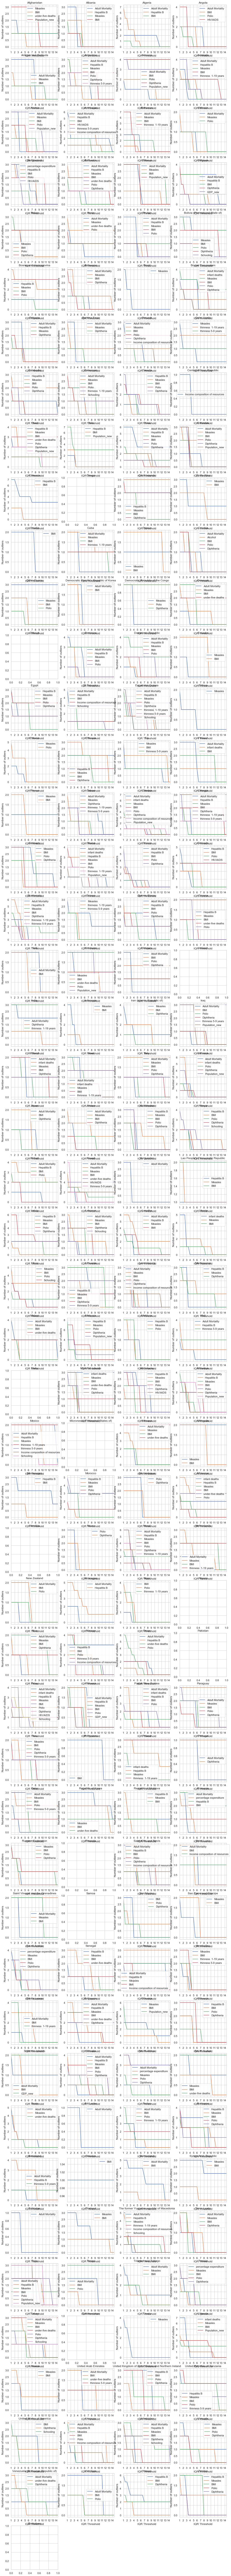

<Figure size 432x288 with 0 Axes>

In [128]:
outlier_viz = plt.figure(figsize=(16, 200))

countries_to_be_winsorized = {}

index = 1
for country in countries:

    does_country_have_outliers, outlying_variables = tukeys_visualizers(
        data4.loc[data4['Country'] == country], numeric_cols, True)

    plt.subplot(50, 4, index)
    plt.title(country)
    index += 1

    if does_country_have_outliers:
        countries_to_be_winsorized[country] = outlying_variables

plt.show()
plt.tight_layout()

#### Winsorizing outliers

Clearly, a lot of outliers lie in the dataset, and some values are so larger than 14 times the IQR! 

Naturally, we winsorize these variables at the 85th percentile.

In [139]:
data5 = data4.copy()
data5['corrected'] = ""

for col in numeric_cols:
    data5[col + '_corrected'] = ""

for country in countries:
    corrected = False

    if country in countries_to_be_winsorized:
        data5['corrected'].loc[data5['Country'] == country] = 1
        corrected = True
    else:
        data5['corrected'].loc[data5['Country'] == country] = 0

    for col in numeric_cols:
        if corrected and col in countries_to_be_winsorized[country]:
            data5[col + '_corrected'].loc[data5['Country'] == country] = winsorize(
                data5[col].loc[data5['Country'] == country], limits=(0, 0.03))
            
        else:
            data5[col + '_corrected'].loc[data5['Country'] == country] = data5[col].loc[data5['Country'] == country]

In [142]:
data5 = data5.drop(columns = numeric_cols)

numeric_cols = list(data5.columns)
numeric_cols.remove('Country')
numeric_cols.remove('Status')
numeric_cols.remove('corrected')
numeric_cols.remove('iso2Code')
numeric_cols.remove('region')
numeric_cols

['Year',
 'Life expectancy',
 'Adult Mortality_corrected',
 'infant deaths_corrected',
 'Alcohol_corrected',
 'percentage expenditure_corrected',
 'Hepatitis B_corrected',
 'Measles_corrected',
 'BMI_corrected',
 'under-five deaths_corrected',
 'Polio_corrected',
 'Total expenditure_corrected',
 'Diphtheria_corrected',
 'HIV/AIDS_corrected',
 'thinness  1-19 years_corrected',
 'thinness 5-9 years_corrected',
 'Income composition of resources_corrected',
 'Schooling_corrected',
 'GDP_new_corrected',
 'Population_new_corrected']

### Converting numeric columns to float and 'Status' to dummy

In [165]:
data5 = pd.concat([data5, pd.get_dummies(data5['Status'], drop_first = True)], axis = 1)

for col in numeric_cols:
    data5[col] = data5[col].astype('float')
    
data_ready = data5.copy()

## Data Exploration

In [152]:
data_ready.groupby(by=['Status']).mean()

Year  Life expectancy  corrected  \
Status                                                
Developed   2007.500000        79.197852   1.000000   
Developing  2007.522671        67.111465   0.989283   

            Adult Mortality_corrected  infant deaths_corrected  \
Status                                                           
Developed                   79.685547                 1.494141   
Developing                 182.833195                36.384171   

            Alcohol_corrected  percentage expenditure_corrected  \
Status                                                            
Developed            9.826736                       2703.600380   
Developing           3.482929                        323.470285   

            Hepatitis B_corrected  Measles_corrected  BMI_corrected  ...  \
Status                                                               ...   
Developed               83.302083         499.005859      51.803906  ...   
Developing              74.643154        2824.926216      35.435326  ...   

            Total expenditure_corrected  Diphtheria_corrected  \
Status                                                          
Developed                      7.554042             93.476562   
Developing                     5.573859             79.669002   

            HIV/AIDS_corrected  thinness  1-19 years_corrected  \
Status                                                           
Developed             0.100000                        1.320703   
Developing            2.088664                        5.592935   

            thinness 5-9 years_corrected  \
Status                                     
Developed                       1.296680   
Developing                      5.635242   

            Income composition of resources_corrected  Schooling_corrected  \
Status                                                                       
Developed                                    0.852489            15.845474   
Developing                                   0.582310            11.219256   

            GDP_new_corrected  Population_new_corrected  Developing  
Status                                                               
Developed        19718.121727              1.769026e+07           0  
Developing        4114.267886              1.473458e+07           1  

[2 rows x 22 columns]

It becomes quickly evident that the `Developing` countries in the Sub-Saharan `region` have some of the worst

(22.0, 0.0)

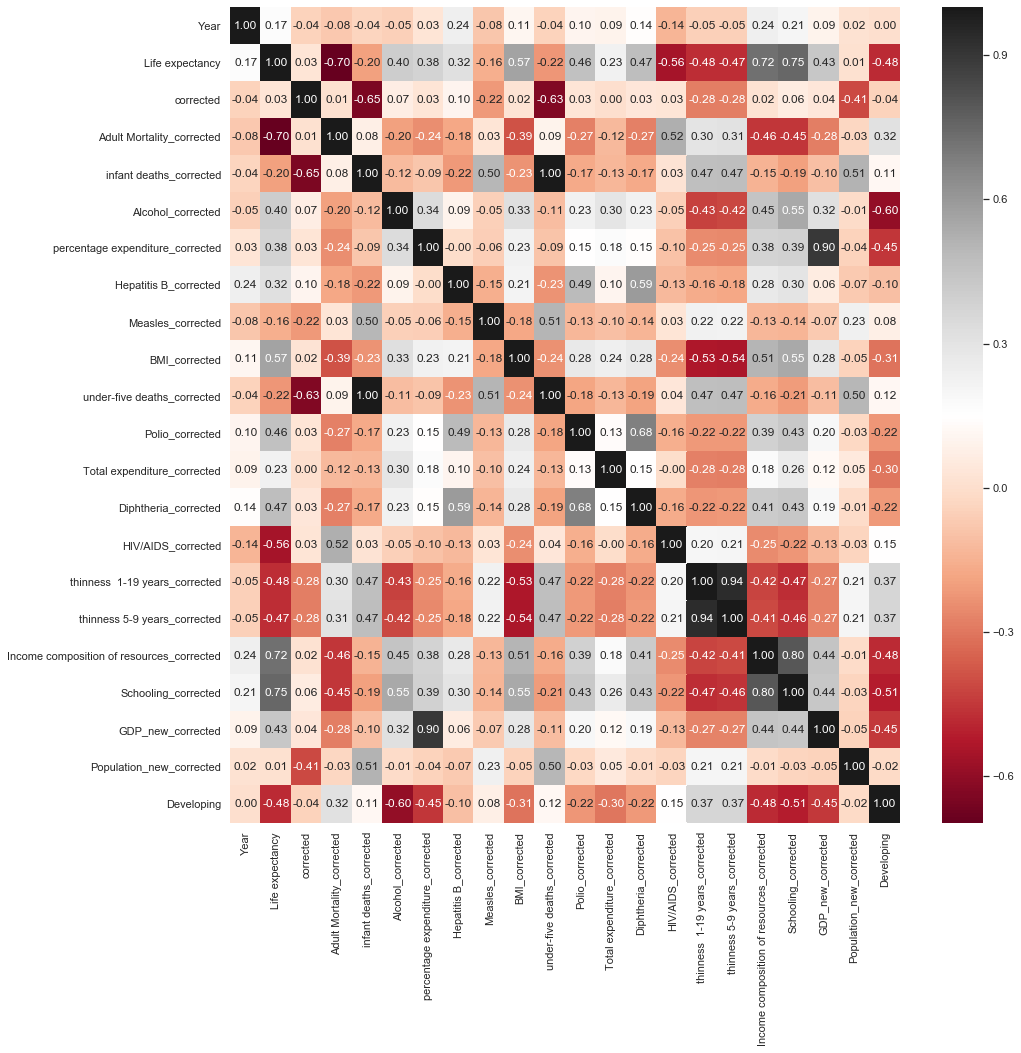

In [154]:
corr = data_ready.corr()

plt.figure(figsize=(15, 15))
ax = sns.heatmap(corr, annot=True, fmt = '.2f', cmap='RdGy')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [155]:
imp_vars = ['Adult Mortality_corrected', 'BMI_corrected', 'HIV/AIDS_corrected',
            'Income composition of resources_corrected', 'Schooling_corrected', 'Developing', 'Life expectancy',
           'thinness  1-19 years_corrected', 'thinness 5-9 years_corrected']

In [163]:
numeric_cols.remove('Year')
numeric_cols

['Life expectancy',
 'Adult Mortality_corrected',
 'infant deaths_corrected',
 'Alcohol_corrected',
 'percentage expenditure_corrected',
 'Hepatitis B_corrected',
 'Measles_corrected',
 'BMI_corrected',
 'under-five deaths_corrected',
 'Polio_corrected',
 'Total expenditure_corrected',
 'Diphtheria_corrected',
 'HIV/AIDS_corrected',
 'thinness  1-19 years_corrected',
 'thinness 5-9 years_corrected',
 'Income composition of resources_corrected',
 'Schooling_corrected',
 'GDP_new_corrected',
 'Population_new_corrected']

In [167]:
data_ready.dtypes

Country                                       object
Year                                         float64
Status                                        object
Life expectancy                              float64
iso2Code                                      object
region                                        object
corrected                                      int64
Adult Mortality_corrected                    float64
infant deaths_corrected                      float64
Alcohol_corrected                            float64
percentage expenditure_corrected             float64
Hepatitis B_corrected                        float64
Measles_corrected                            float64
BMI_corrected                                float64
under-five deaths_corrected                  float64
Polio_corrected                              float64
Total expenditure_corrected                  float64
Diphtheria_corrected                         float64
HIV/AIDS_corrected                           f

In [170]:
data_ready.dropna(inplace=True)

In [171]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(data_ready[numeric_cols])

sklearn_pca = PCA(n_components=1)
data_ready['IMP_VARS1'] = sklearn_pca.fit_transform(X)

sklearn_pca.explained_variance_ratio_

array([0.32846444])

(24.0, 0.0)

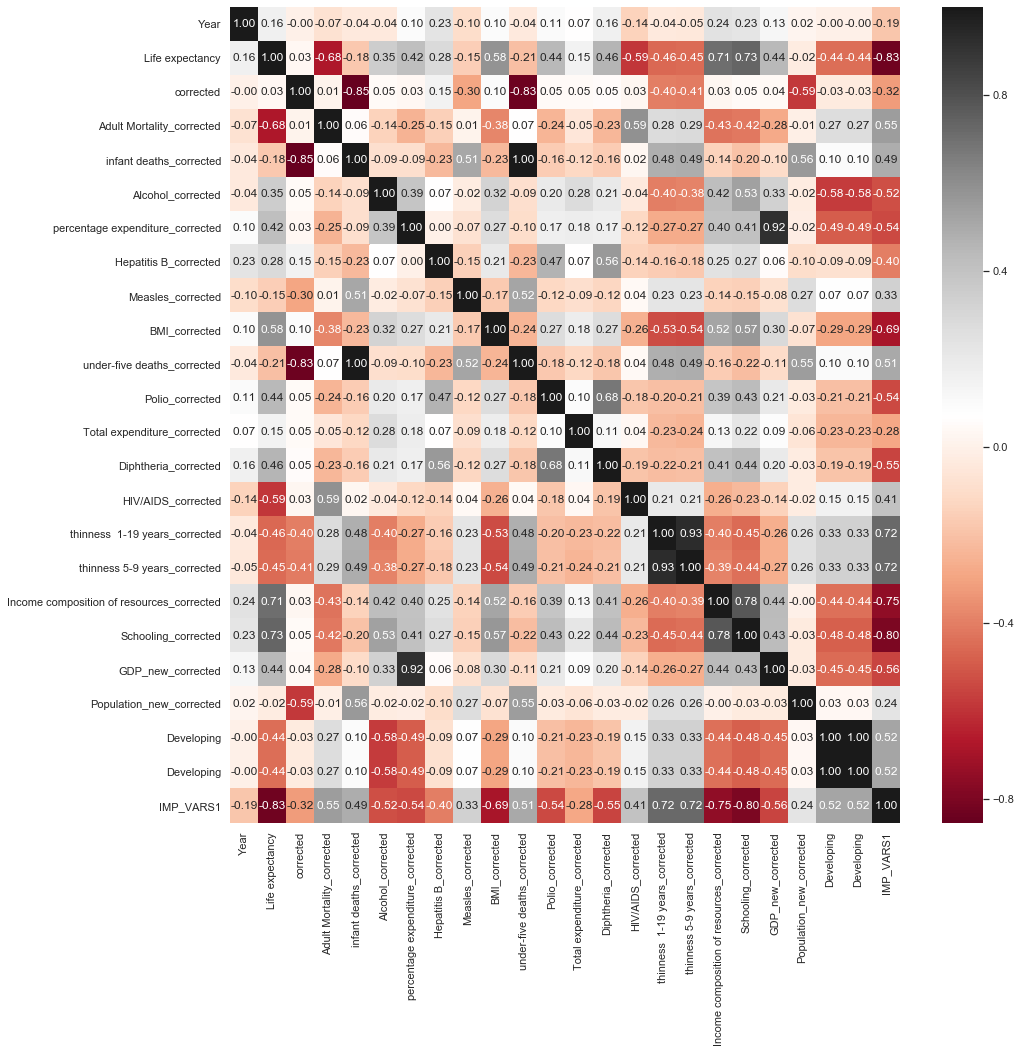

In [173]:
corr = data_ready.corr()

plt.figure(figsize=(15, 15))
ax = sns.heatmap(corr, annot=True, fmt = '.2f', cmap='RdGy')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [196]:
data5[['Country', 'GDP_new_corrected', 'Population_new_corrected']].groupby(by = 'Country').mean()

GDP_new_corrected  \
Country                                                                 
Afghanistan                                                340.015425   
Albania                                                   2119.726679   
Algeria                                                   2847.853392   
Angola                                                    1975.143045   
Antigua and Barbuda                                       9759.305728   
Argentina                                                 6998.575103   
Armenia                                                   1999.986318   
Australia                                                34637.565047   
Austria                                                  33827.476309   
Azerbaijan                                                3302.947807   
Bahamas                                                   3371.268690   
Bahrain                                                  11191.247421   
Bangladesh                                                 443.561481   
Barbados                                                 12017.098529   
Belarus                                                   3811.525348   
Belgium                                                  16915.306000   
Belize                                                    3933.012174   
Benin                                                      561.167968   
Bhutan                                                    1353.986946   
Bolivia (Plurinational State of)                          3371.268690   
Bosnia and Herzegovina                                    2245.026024   
Botswana                                                  4498.285431   
Brazil                                                    6143.161794   
Brunei Darussalam                                        19744.808102   
Bulgaria                                                  4938.981821   
Burkina Faso                                               410.372034   
Burundi                                                    137.815321   
Cabo Verde                                                2023.541039   
Cambodia                                                   466.196878   
Cameroon                                                   781.016004   
Canada                                                   29382.907523   
Central African Republic                                   363.055905   
Chad                                                       484.791694   
Chile                                                     6202.344364   
China                                                     2345.303158   
Colombia                                                  3321.660748   
Comoros                                                    630.384334   
Congo                                                     3371.268690   
Cook Islands                                                      NaN   
Costa Rica                                                3957.227286   
Croatia                                                   9056.784719   
Cuba                                                      3180.434884   
Cyprus                                                   13898.885501   
Czechia                                                   3371.268690   
Côte d'Ivoire                                             3371.268690   
Democratic People's Republic of Korea                     3371.268690   
Democratic Republic of the Congo                          3371.268690   
Denmark                                                  33067.407916   
Djibouti                                                   897.999871   
Dominica                                                   722.756650   
Dominican Republic                                        3509.499186   
Ecuador                                                   2005.352468   
Egypt                                                     3371.268690   
El Salvador                          

In [193]:
data5.loc[data5.isna().any(axis = 1)].groupby(by = 'Country').count()

Year  Status  \
Country                                                            
Algeria                                                1       1   
Angola                                                 1       1   
Antigua and Barbuda                                    1       1   
Argentina                                              1       1   
Armenia                                                1       1   
Australia                                              1       1   
Austria                                                1       1   
Azerbaijan                                             1       1   
Bahamas                                               16      16   
Bahrain                                                1       1   
Bangladesh                                             1       1   
Barbados                                               1       1   
Belarus                                                1       1   
Belgium                                                1       1   
Belize                                                 1       1   
Benin                                                  1       1   
Bhutan                                                 1       1   
Bolivia (Plurinational State of)                      16      16   
Bosnia and Herzegovina                                 1       1   
Botswana                                               1       1   
Brazil                                                 1       1   
Brunei Darussalam                                      1       1   
Bulgaria                                               1       1   
Burkina Faso                                           1       1   
Burundi                                                1       1   
Cabo Verde                                             1       1   
Cambodia                                               1       1   
Cameroon                                               1       1   
Canada                                                 1       1   
Central African Republic                               1       1   
Chad                                                   1       1   
Chile                                                  1       1   
China                                                  1       1   
Colombia                                               1       1   
Comoros                                                1       1   
Congo                                                 16      16   
Cook Islands                                           1       1   
Costa Rica                                             1       1   
Croatia                                                1       1   
Cuba                                                   1       1   
Cyprus                                                 1       1   
Czechia                                               16      16   
Côte d'Ivoire                                         16      16   
Democratic People's Republic of Korea                 16      16   
Democratic Republic of the Congo                      16      16   
Denmark                                               16      16   
Djibouti                                               1       1   
Dominica                                               1       1   
Dominican Republic                                     1       1   
Ecuador                                                1       1   
Egypt                                                 16      16   
El Salvador                                            1       1   
Equatorial Guinea                                      1       1   
Eritrea                                                4       4   
Estonia                                                1       1   
Ethiopia                                               1       1   
Fiji                                                   1       1   
Finland                                 

In [183]:
data_ready.groupby(by=['region', 'Status']).count()

Country  Year  Life expectancy  \
region                     Status                                       
East Asia & Pacific        Developed        45    45               45   
                           Developing      255   255              255   
Europe & Central Asia      Developed       255   255              255   
                           Developing      271   271              271   
Latin America & Caribbean  Developing      390   390              390   
Middle East & North Africa Developed        15    15               15   
                           Developing      240   240              240   
North America              Developing       15    15               15   
South Asia                 Developing      121   121              121   
Sub-Saharan Africa         Developing      582   582              582   

                                       iso2Code  corrected  \
region                     Status                            
East Asia & Pacific        Developed         45         45   
                           Developing       255        255   
Europe & Central Asia      Developed        255        255   
                           Developing       271        271   
Latin America & Caribbean  Developing       390        390   
Middle East & North Africa Developed         15         15   
                           Developing       240        240   
North America              Developing        15         15   
South Asia                 Developing       121        121   
Sub-Saharan Africa         Developing       582        582   

                                       Adult Mortality_corrected  \
region                     Status                                  
East Asia & Pacific        Developed                          45   
                           Developing                        255   
Europe & Central Asia      Developed                         255   
                           Developing                        271   
Latin America & Caribbean  Developing                        390   
Middle East & North Africa Developed                          15   
                           Developing                        240   
North America              Developing                         15   
South Asia                 Developing                        121   
Sub-Saharan Africa         Developing                        582   

                                       infant deaths_corrected  \
region                     Status                                
East Asia & Pacific        Developed                        45   
                           Developing                      255   
Europe & Central Asia      Developed                       255   
                           Developing                      271   
Latin America & Caribbean  Developing                      390   
Middle East & North Africa Developed                        15   
                           Developing                      240   
North America              Developing                       15   
South Asia                 Developing                      121   
Sub-Saharan Africa         Developing                      582   

                                       Alcohol_corrected  \
region                     Status                          
East Asia & Pacific        Developed                  45   
                           Developing                255   
Europe & Central Asia      Developed                 255   
                           Developing                271   
Latin America & Caribbean  Developing                390   
Middle East & North Africa Developed                  15   
                           Developing                240   
North America              Developing                 15   
South Asia                 Developing                121   
Sub-Saharan Africa         Developing                582   

                                       percentage expenditure_corrected  \
region     